In [86]:
# Copyright (c) 2017 Yazabi Predictive Inc.

#################################### MIT License ####################################
#                                                                                   #
# Permission is hereby granted, free of charge, to any person obtaining a copy      #
# of this software and associated documentation files (the "Software"), to deal     #
# in the Software without restriction, including without limitation the rights      #
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell         #
# copies of the Software, and to permit persons to whom the Software is             #
# furnished to do so, subject to the following conditions:                          #
#                                                                                   #
# The above copyright notice and this permission notice shall be included in all    #
# copies or substantial portions of the Software.                                   #
#                                                                                   #
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR        #
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,          #
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE       #
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER            #
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,     #
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE     #
# SOFTWARE.                                                                         #
#                                                                                   #
#####################################################################################

#### Objective: 

Explore the (unnormalized) Communities and Crime dataset (http://archive.ics.uci.edu/ml/datasets/communities+and+crime+unnormalized) and predict the per capita incidence of violent crime in cities throughout the United States. 

Use XGBoost (extreme gradient boosting) to predict the number of violent crimes per capita (stored in the dataset under the heading ‘ViolentCrimesPerPop’) from the demographic and other data provided.  

#### Background: 

The Communities and Crime dataset contains information gathered from a variety of sources, including the 1990 United States Census, the 1990 Law Enforcement Management and Administrative Statistics survey and the 1995 FBI Uniform Crime Report. The data consists of demographic, geographic and social data collected for over two thousand communities in the U.S., as well as reported rates of per captia violent crime, murder, arson and a number of other felonies. 

# 1. Data Preprocessing

In [87]:
import pandas as pd
import numpy as np
import json
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn import preprocessing
import codecs
import csv 
import xgboost as xgb
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings("ignore")

In [88]:
def load_data(filepath):
    """Loads in data from the CSV file contained in the location given by
    filepath.

    params:

    :filepath: a string containing the path to the data-containing CSV.

    returns: dataset, a Pandas DataFrame that contains the crime dataset.
    Note: this DataFrame should not contain the columns 'communityname',
    'state', 'countyCode', 'communityCode' or 'fold', since these columns are
    neither useful as inputs or labels. Hint: pd.DataFrame.drop() is a function
    you'll want to use for this.
    """
    pd.set_option('display.max_columns', 500)
    column_names = pd.read_json('all_headers.json') 

    dataset=pd.read_csv('CommViolPredUnnormalizedData.txt', header=None, names=column_names[0].tolist())  
    dataset.drop(['communityname', 'state', 'countyCode', 'communityCode', 'fold'], axis='columns',inplace=True)
    return  dataset 

In [89]:
def drop_nan_cols(dataset,drop_threshold): 
    """Replaces question marks '?' from the Pandas DataFrame taken as input with
    np.NaN values, and then drops any columns that contain fewer than
    drop_threshold features (you can do that using pd.Series.isnull().sum()).
    Note that the drop_threshold value will have to be greater than 221, since
    that's how many '?'s there are in the 'ViolentCrimesPerPop' column, which
    we want to analyze.

    params:

    :dataset: a Pandas DataFrame as loaded by the load_data() function.
    :usabel_columns: a list of strings, each of which provides the name of a
    column that can be used as an input or label. usable_columns will therefore
    contain all the entries in all_headers, minus 'communityname', 'state',
    'countyCode', 'communityCode' or 'fold' (which happen to be the first 5
    entries).
    :drop_threshold: the number of NaN entries above which we remove a column
    from the dataset (must be greater than 221 in order to avoid throwing
    away the 'ViolentCrimesPerPop' column, which we want to analyze)

    returns: reduced_dataset (the dataset taken as input, with any columns
    containing more than drop_threshold NaN entries dropped), and
    features_to_drop (a list of strings containing the names of any dropped
    features).
    """
    
    dataset=dataset.applymap(lambda x: np.nan if x=='?' else x)
    reduced_dataset=dataset.drop(dataset.isnull().sum().gt(drop_threshold)[lambda x: x].index , axis='columns')

    return  reduced_dataset

In [90]:
def drop_nan_rows(reduced_dataset):
    """Removes any rows in the dataset taken as input, that contain NaN
    values.

    params:

    :dataset: a Pandas DataFrame containing the reduced_dataset returned by
    drop_nan_cols().

    return: the dataset, where any of its NaN-containing rows have been
    dropped.
    """

    return reduced_dataset.dropna(how='any', axis='index', inplace=True)

In [91]:
def split_train_and_test(dataset,test_frac=0.25):
    """Splits the input dataset into randomly-shuffled training and testing
    sets.

    params:

    :dataset: a Pandas DataFrame containing the total dataset, which is to be
    split into training and testing components.
    :test_frac: the fraction of samples to be reserved for testing.

    returns: train_data and test_data, the split training and testing sets as
    Pandas DataFrames.
    """
    from sklearn.model_selection import train_test_split
    
    X=dataset[list(set(list(dataset.columns))-set(['ViolentCrimesPerPop']))]
    y=dataset['ViolentCrimesPerPop']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
    
    return X_train, X_test, y_train, y_test

In [92]:
def find_retained_labels(label_headers,features_to_drop):
    """Identifies the names of the columns that will be used as labels, and that
    haven't been dropped from the dataset yet due to having too many NaN entries.

    params:

    :label_headers: a list of strings, each of which is the name of a column
    that contains a feature to be predicted (these features are 'murders',
    'murdPerPop', 'rapes', 'rapesPerPop', 'robberies', 'robbbPerPop', 'assaults',
    'assaultPerPop', 'burglaries', 'burglPerPop', 'larcenies', 'larcPerPop',
    'autoTheft', 'autoTheftPerPop', 'arsons', 'arsonsPerPop',
    'ViolentCrimesPerPop', and 'nonViolPerPop')
    :features_to_drop: a list of strings, each of which is the name of a column
    that contains a feature to be dropped due to its containing too many NaN
    entries (according to drop_nan_cols() and drop_nan_rows())

    returns: retained_label_headers, a list of strings, each of which contains
    the name of a feature to be predicted, but that hasn't been dropped due to
    its NaN content.
    """
    retained_label_headers=list(set(list(dataset.columns))-set(label_headers))
    label_headers = pd.read_json('label_headers.json')[0].tolist()

    return retained_label_headers

In [93]:
def change_obj_to_int(inputs):
    """Converts the 'OtherPerCap' column, which is initially an object type,
    into int type, which it needs to be in order to be fed into your downstream
    learning algorithm.

    params:

    :inputs: a Pandas DataFrame that contains the inputs that will be taken in
    by the downstream learning algorithm.

    returns: inputs, a Pandas DataFrame for which the 'OtherPerCap' column
    is set to the type int.
    """
    inputs['OtherPerCap']=inputs['OtherPerCap'].astype(int)
    for col in inputs.columns[inputs.dtypes=='object']:
        inputs[col] = pd.to_numeric(inputs[col], errors='coerce')
    return inputs 

In [94]:
def plot_correlations(matrix):
    """Plots the correlations matrix obtained from the data provided.

    params:

    :matrix: the correlations matrix generated by pd.DataFrame.corr(),
    which provides the correlations between each input and the label
    of interest (in this case, 'ViolentCrimesPerPop').

    returns: nothing.
    """
    
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.matshow(matrix)
    plt.xticks(range(len(matrix.columns)), matrix.columns);
    plt.yticks(range(len(matrix.columns)), matrix.columns);
    plt.show()
    return

In [95]:
def find_uncorrelated_cols(train_inputs, train_labels, drop_threshold=0.1,
                            analyzed_label='ViolentCrimesPerPop'):
    """Builds a correlations matrix from train_inputs and train_labels,
    and identifies any columns in train_inputs that is too weakly correlated with
    the analyzed_label (which will usually be 'ViolentCrimesPerPop', but which
    you can change if you wish).

    params:

    :train_inputs: a Pandas DataFrame that contains the training data.
    :train_labels: a Pandas DataFrame that contains the training labels,
    which include 'ViolentCrimesPerPop', among others.
    :drop_threshold: a float that provides the minimum correlation between
    each input feature and the analyzed_label in order for the feature not
    to be droped.
    :analyzed_label: a string providing the name of the label feature to be
    analyzed. By default, this should be 'ViolentCrimesPerPop'.

    returns: dropped_features, a list of strings, each of which indicates the
    name of a feature that will be dropped from our model because it's too
    uncorrelated to the feature indicated by analyzed_label
    """
    
    
    dropped_features = set() 
    corr_matrix=train_inputs.corr()

    for i in range(len(corr_matrix.columns)):
        if corr_matrix.loc[corr_matrix.iloc[0].index[i],analyzed_label] < drop_threshold:
            colname = corr_matrix.columns[i] # getting the name of column
            dropped_features.add(colname)
                
    return dropped_features

In [96]:
def drop_uncorrelated_cols(inputs, dropped_features): #labels, 
    """Removes features that have been deemed insufficiently useful for our
    learning algorithm.

    params:

    :inputs: a Pandas DataFrame containing the data to be fed as input to our
    learning algorithm.
    :labels: a Pandas DataFrame containing the labels to be used by the
    learning algorithm.
    :dropped_features: a list of strings providing the names of features or labels
    that are to be dropped from the inputs DataFrame.

    returns: inputs and labels, both Pandas DataFrames respectively providing
    the inputs and labels to the learning algorithm, with the dropped_features
    removed.
    """
    inputs.drop(dropped_features ,axis='columns', inplace=True)
    labels=pd.DataFrame(inputs.columns)
    return inputs, labels

In [97]:
def normalize_dataset(X_train, X_test, y_train, y_test):
    """Normalizes all features in the dataset provided as input.

    params:

    :dataset: a Pandas DataFrame whose values are to be normalized by column.

    returns: dataset, a Pandas DataFrame whose values have been normalized to
    between 0 and 1. Hint: you'll probably want to use the MinMaxScaler()
    function, which has been imported for you at the top of this script.
    """
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler()
    
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test) 
    y_train_scaled = scaler.fit_transform(y_train)
    y_test_scaled = scaler.transform(y_test)     

    return X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled

In [98]:
def generate_data(analyzed_label='ViolentCrimesPerPop',
                    all_headers_filepath='all_headers.json',
                    label_headers_filepath='label_headers.json',
                    dataset_filepath='CommViolPredUnnormalizedData.txt',
                    drop_threshold=0.1): #plot_correlations=True,
    """Generates inputs and labels for testing and training sets. You'll want
    to call all of the functions above to do so. Hint: be sure to follow
    the walkthrough if you need some additional detail on how to do this.

    params:

    :analyzed_label: a string providing the name of the feature to be analyzed.
    Should default to 'ViolentCrimesPerPop'.
    :plot_correlations: a boolean which, if True, will cause the correlations
    matrix to be plotted.
    :drop_threshold: a float providing the correlation threshold below which
    a feature will be dropped.

    returns: train_inputs, train_labels, test_inputs and test_labels, all of
    which are Pandas DataFrames, respectively containing the fully processed
    training inputs and labels, and testing inputs and labels.
    """

    dataset=load_data(dataset_filepath)
    reduced_dataset=drop_nan_cols(dataset,drop_threshold=221)
    drop_nan_rows(reduced_dataset)
    
    plot_correlations(reduced_dataset.corr())
    reduced_dataset=change_obj_to_int(reduced_dataset)
    dropped_features=find_uncorrelated_cols(reduced_dataset, pd.DataFrame(reduced_dataset.columns))
    inputs, labels=drop_uncorrelated_cols(reduced_dataset, dropped_features)
    
    X_train, X_test, y_train, y_test =split_train_and_test(inputs)
    X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled=normalize_dataset(X_train, X_test, y_train, y_test)
    
    return X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled

# 2. Train and Predict

In [99]:
cv_params = {'max_depth': [3,5,7], 'min_child_weight': [3,5,7], 'learning_rate': [0.1,0.01],
        'subsample': [0.5,0.7,0.9], 'n_estimators': [100],
        'colsample_bytree': [0.6], 'objective': ['reg:logistic'], 'gamma': [0.5],
        'reg_lambda': [0.5], 'base_score': [0.5]} #, 'booster': ['gbtree']

In [100]:
def find_best_parameters(): 
    """Runs a grid search over parameter space by using GridSearchCV on the
    xgb.XGBRegressor() model, and identifies the best parameters for the model
    among the options in cv_params.

    params:

    :train_inputs: a Pandas DataFrame providing the inputs to the learning
    algorithm.
    :train_labels: a Pandas DataFrame providing the labels to the learning
    algorithm.
    :cv_params: a dict object containing the parameter values to be tested.

    returns: optimized_params, a dictionary object containing the optimal
    parameter values identified by the grid search.
    """

    
    xgbreg = GridSearchCV(xgb.XGBRegressor(), param_grid = cv_params, scoring='mean_squared_error', cv = 5, n_jobs = -1)
    xgbreg.fit(X_train_scaled, y_train_scaled)
    model_grid = xgbreg.best_estimator_.get_params()

    print('The optimized parameters are: ', model_grid)
    return model_grid 

In [101]:
def find_optimal_num_trees(model_grid,xgdmat,num_boost_round=3000,
                            early_stopping_rounds=100):
    """Determines the best number of trees to use in order to minimize
    cross-validation error. Hint: you'll want to use the xgb.cv() function
    for this.

    params:

    :optimized_params: a dictionary object providing the parameter values that
    have been found to be optimal based on a previously executed grid search.
    :dmat: an xgboost DMatrix object in the format
    xgb.DMatrix(train_inputs, train_labels['ViolentCrimesPerPop']).
    :num_boost_round: an int providing the number of boosting iterations used
    by the algorithm.
    :early_stopping_rounds: an int providing the number of consecutive boosting
    rounds over which the validation loss must not decrease before the algorithm
    stops.

    returns: optimal_num_trees, an int indicating the optimal number of decision
    trees to be added together.
    """

    cv_xgb = xgb.cv(params = model_grid, dtrain = xgdmat, num_boost_round = 3000,
                    nfold = 5, metrics = ['error'], early_stopping_rounds = 100)
    optimal_num_trees = len(cv_xgb) - 1    
    
    print('Optimal Number of Trees is ', optimal_num_trees)
    return optimal_num_trees

In [102]:
def build_model(train_inputs, train_labels, cv_params=cv_params, drop_threshold=0.1):
    """Builds and trains the XGBoost model using the grid of parameters provided
    as input.

    params:

    :train_inputs: a Pandas DataFrame containing the training input data.
    :train_labels: a Pandas DataFrame containing the training labels.
    :cv_params: a dictionary object providing the grid of parameter values
    to be explored in the search for the optimal set of XGBoost parameters.
    :drop_threshold: a float indicating the minimum correlation between an
    input feature and the label being investigated (generally,
    'ViolentCrimesPerPop'), below which we will discard the feature.

    returns: final_gb, the XGBoost model trained using the optimized parameters
    from cv_params.
    """

    optimized_params = find_best_parameters()
        
    xgdmat = xgb.DMatrix(X_train_scaled, y_train_scaled)
    final_gb = xgb.train(optimized_params, xgdmat, num_boost_round = 
                         find_optimal_num_trees(optimized_params,xgdmat)) 

    return final_gb

In [103]:
def assess_model(model, test_inputs, test_labels):
    """Calculates the mean absolute error that results from the predictions
    of the model, taken as input, based on the testing data provided.
    Suggestion: first convert the test_inputs into an xgb.DMatrix(), and then
    use scikit-learn's mean_absolute_error function, which has been imported
    for you at the top of the script.

    params:

    :model: an XGBoost model that has been trained on an optimized set of
    parameters.
    :test_inputs: a Pandas DataFrame providing the testing input data.
    :test_labels a Pandas DataFrame providing the testing labels.

    returns: mae, the mean absolute error obtained by applying the model
    to the testing data.
    """
    from sklearn.metrics import accuracy_score
    test_inputs_dmat = xgb.DMatrix(test_inputs)
    y_pred = model.predict(test_inputs_dmat) 
    
    mae = mean_absolute_error(y_test_scaled, y_pred, sample_weight=None, multioutput='uniform_average')

    return mae

In [104]:
def determine_importances(model):
    """Determines the importances of each feature in the model using
    the XGBoost get_fscore() function.

    params:

    :model: the trained XGBoost model.

    returns: importances, a dictionary object containing the importances
    assigned to each feature.
    """
    
    importances = model.get_fscore()

    return importances

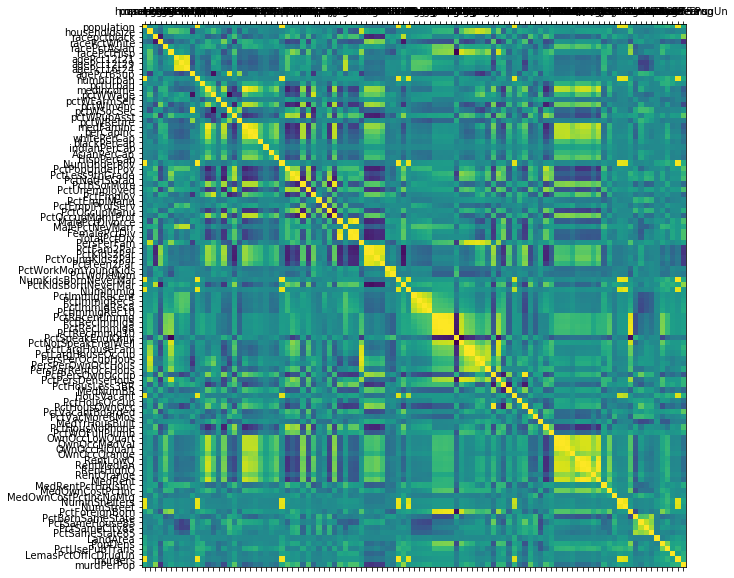

The optimized parameters are:  {'base_score': 0.5, 'colsample_bylevel': 1, 'colsample_bytree': 0.6, 'gamma': 0.5, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 3, 'missing': None, 'n_estimators': 100, 'nthread': -1, 'objective': 'reg:logistic', 'reg_alpha': 0, 'reg_lambda': 0.5, 'scale_pos_weight': 1, 'seed': 0, 'silent': True, 'subsample': 0.9}
Optimal Number of Trees is  30
Mean Absolute Error is  0.025905647815


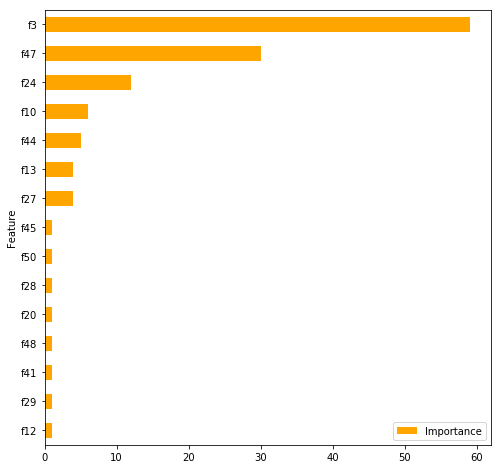

In [105]:
# if __name__ == "__main__":
    #In this block, write the script that you want to have run automatically
    #as soon as this module is called. You'll want to do the following:
    # 1. load the preprocessed training and testing data using dp.generate_data()
    # 2. plot the correlations matrix using dp.plot_correlations()
    # 3. build your optimized model using build_model()
    # 4. calculate and print the mean absolute error that your model obtains
    # on the testing data using assess_model()
    # 5. find the importances of each feature using importance_frame(), and
    # plot them.
    
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = generate_data()
final_gb = build_model(X_train_scaled, y_train_scaled)
print('Mean Absolute Error is ', assess_model(final_gb, X_test_scaled, y_test_scaled))
importances = determine_importances(final_gb)

importance_frame = pd.DataFrame({'Importance': list(importances.values()), 'Feature': list(importances.keys())})
importance_frame.sort_values(by = 'Importance', inplace = True)
importance_frame.plot(kind = 'barh', x = 'Feature', figsize = (8,8), color = 'orange')
plt.show()